# Exercise: Mandelbrot set

In this excercise, We will be computing the famous [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set). 

The Mandelbrot set is the set of [complex numbers](https://en.wikipedia.org/wiki/Complex_number) $c \in \mathbb{C}$ for which the iteration,

$$z_{n+1} = z_n^2 + c,$$

converges (i.e. does not diverge to infinity), when iterated from $z_0 = 0$. 

The beauty of the Mandelbrot set is that it's [self-similar](https://en.wikipedia.org/wiki/Self-similarity). So if you start to zoom into the set, you may start to see the same pattern showing up again, as you can see in the [gif](https://en.wikipedia.org/wiki/Mandelbrot_set#/media/File:Mandelbrot_sequence_new.gif) of its wikipedia page.

A complex number $c$ belongs to the Mandelbrot set if and only if $ |z_{n}| \le 2 $ for all $ n \ge 0 $ . We can use this property to validate if $c$ is within the Mandelbrot set.

As you may already noticed, we need to investigate infinity number of $c$. And for each $c$, we need to compute infinite number of iterations to validate if it is within the Mandelbrot set. Of course we will not do either of them (hey this is not a mathematics workshop -_^). We will simply:

1. Define a finite extent;
2. Select a finite number of complex numbers within this extent;
3. Validate each complex number with a finite number of iterations. If in any iteration |z_{n}| \ge 2 $, the number is not in the Mandelbrot set. 

In [1]:
# Define a finite extent
CENTER = -0.8 + 0.0j # Location of the extent center
EXTENT = 3.0 + 3.0j # Extent length (real + imaginary)

# Select finite number of complex numbers
# In total width*height complex numbers will be inspected 
WIDTH = 256  # number of elemtes along the real axis
HEIGHT = 256 # number of elemtes along the imaginary axis

# Finite iterations
MAX_ITER = 256 # Max number of iterations per complex number

We will start with a native for loop implementation to compute and visualize the Mandelbrot set within a certain extent. 

In [2]:
import numpy as np

def compute_mandelbrot(width=WIDTH, height=HEIGHT, max_iter=MAX_ITER, center=CENTER, extent=EXTENT):
    niters = np.zeros((width, height), int)
    scale = max(extent.real/width, extent.imag/height)

    # Loop through all selected complex number within the extent
    for j in range(height):
        for i in range(width):
            c = center + (i - width // 2 + (j - height //2) * 1j) * scale
            z = 0

            # Per complex number, validate it for a finite number of iterations
            for k in range(max_iter):
                z = z**2 + c

                # if the modulus (or absolute value) of the complex number is greater than 2,
                # it will diverge, thus not within Mandelbrot set
                if np.absolute(z) > 2.0: 
                    break

            niters[j, i] = k
    return niters

We call the function to compute the iteration numbers per complex number:

In [3]:
niters = compute_mandelbrot()

And we can visualize the interation numbers of all complex numbers we validated:

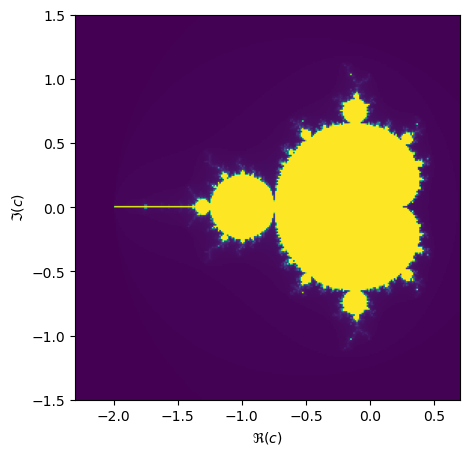

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
c0, c1 = CENTER - EXTENT / 2, CENTER + EXTENT / 2
plot_extent = (c0.real, c1.real, c0.imag, c1.imag)

ax.imshow(niters, origin='lower', extent=plot_extent)
ax.set_xlabel("$\Re(c)$")
ax.set_ylabel("$\Im(c)$") ;

All the yellow pixels here represents the complex number survived through the max number iterations, thus they are considered as within the Mandelbrot set in our example. So the function seem to be working, but can we make it faster?

In [5]:
%timeit compute_mandelbrot()

3.73 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes a few seconds for now to validate all numbers within the given extent. Can you use the optimization skills you have learnt in this workshop to accelerate the given implementation?

## Hint
For starters, think on how you can separate the iteration loop and the outer two loops for mapping over the complex numbers:

In [6]:
def mandelbrot(c, max_iter=MAX_ITER):
    z = 0

    # Per complex number, validate it for a finite number of iterations
    for k in range(MAX_ITER):
        z = z**2 + c

        # if the modulus (or absolute value) of the complex number is greater than 2,
        # it will diverge, thus not within Mandelbrot set
        if np.absolute(z) > 2.0: 
            break

    return k


def compute_mandelbrot(width=WIDTH, height=HEIGHT, center=CENTER, extent=EXTENT, max_iter=MAX_ITER):
    niters = np.zeros((width, height), int)
    scale = max(extent.real / width, extent.imag / height)

    # Loop through all selected complex number within the extent
    for j in range(height):
        for i in range(width):
            c = center + (i - width // 2 + (j - height //2) * 1j) * scale
            k = mandelbrot(c, max_iter)
            niters[j, i] = k
    return niters

Now we can think about optimizing the inner loop first, and then find ways of running the outer loop in parallel.